In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchaudio
from torch.utils.data import DataLoader

import os, shutil, math
import time
from datetime import datetime
from itertools import islice
from typing import List
import IPython

from dataset.dcase_dataset import DCASE_SELD_Dataset, InfiniteDataLoader, _get_padders
from evaluation.dcase2022_metrics import cls_compute_seld_results
from evaluation.evaluation_dcase2022 import write_output_format_file, get_accdoa_labels, get_multi_accdoa_labels, determine_similar_location, all_seld_eval
from solver import Solver
from feature import my_feature

import augmentation.spatial_mixup as spm
import torch_audiomentations as t_aug
from parameters import get_parameters
import utils
import plots
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif',
              font_scale=1, color_codes=True, rc={'pcolor.shading': 'auto'})

%load_ext autoreload
%autoreload 2

In [ ]:
utils.seed_everything(1234)

def get_audiomentations(p=0.5, fs=24000):
    from augmentation.spliceout import SpliceOut
    # Initialize augmentation callable
    apply_augmentation = t_aug.SomeOf((2, None),
        transforms=[
            t_aug.Gain(p=p, min_gain_in_db=-15.0, max_gain_in_db=5.0, mode='per_example', p_mode='per_example'),
            t_aug.PolarityInversion(p=p, mode='per_example', p_mode='per_example'),
            t_aug.PitchShift(p=p, min_transpose_semitones=-1.5, max_transpose_semitones=1.5, sample_rate=fs, mode='per_example', p_mode='per_example'),
            t_aug.AddColoredNoise(p=p, min_snr_in_db=6.0, max_snr_in_db=30.0, min_f_decay=-2.0, max_f_decay=2.0, sample_rate=fs, mode='per_example', p_mode='per_example'),
            t_aug.BandStopFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.1, sample_rate=fs, p_mode='per_example'),
            t_aug.LowPassFilter(p=p,  min_cutoff_freq=1000, max_cutoff_freq=5000, sample_rate=fs, p_mode='per_example'),
            t_aug.HighPassFilter(p=p, min_cutoff_freq=250, max_cutoff_freq=1500, sample_rate=fs, p_mode='per_example'),
            t_aug.BandPassFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.5, sample_rate=fs, p_mode='per_example'),
            #SpliceOut(p=0.5, num_time_intervals=8, max_width=400, sample_rate=fs, p_mode='per_example')
        ]
    )

    return apply_augmentation

In [ ]:
config = {
    'dataset_root': './data/data_dcase2022',
    'dataset_list': 'dcase2022_devtrain_debug.txt',
    'dataset_chunk_size': math.floor(10 * 24000),
    'order_output': 1,
    'fs': 24000,
}

dataset = DCASE_SELD_Dataset(directory_root=config['dataset_root'],
                             list_dataset=config['dataset_list'],
                             chunk_size=config['dataset_chunk_size'],
                             chunk_mode='random',
                             trim_wavs=20,
                             multi_track=False,
                             num_classes=13,
                             labels_backend='sony',
                             return_fname=False,
                             ignore_labels=True)

audio, _ = dataset[1]
ids = [1]*5
batch = torch.stack([audio for audio, _ in [dataset[id] for id in ids]], dim=0)  # Batch of random slices


In [ ]:
plots.plot_waveform(audio, config['fs'], title='Input')
print(audio.shape)
signal_in_binaural = utils.sh_sig_to_binaural(audio, order=config['order_output'], 
                                              device='cpu', sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=config['fs']))

In [ ]:
augment_transform = get_audiomentations()
signal_out_binaural = augment_transform(signal_in_binaural)
signal_out_binaural = signal_out_binaural['samples']
print(signal_out_binaural)
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=config['fs']))

## Random Augmentations to single file ##

This is the basic method how to apply a selection of random augmentions to a file.
Do note that we are limiting the output afterwards to remove any clipping.

#### NOTE:
PitchShifting can change the spatial characteristics becuase it affects the phase weird soemtimes:

https://github.com/KentoNishi/torch-pitch-shift/blob/master/torch_pitch_shift/main.py


In [ ]:
p, fs, aug_min, aug_max = 1, 24000, 2, 4
apply_augmentation = t_aug.SomeOf((aug_min, aug_max),
    transforms=[
        t_aug.Gain(p=p, min_gain_in_db=-15.0, max_gain_in_db=6.0, mode='per_example', p_mode='per_example'),
        t_aug.PolarityInversion(p=p, mode='per_example', p_mode='per_example'),
        t_aug.PitchShift(p=p, min_transpose_semitones=-1.5, max_transpose_semitones=1.5, sample_rate=fs, mode='per_example', p_mode='per_example'),
        t_aug.AddColoredNoise(p=p, min_snr_in_db=2.0, max_snr_in_db=30.0, min_f_decay=-2.0, max_f_decay=2.0, sample_rate=fs, mode='per_example', p_mode='per_example'),
        t_aug.BandStopFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.1, sample_rate=fs, p_mode='per_example'),
        t_aug.LowPassFilter(p=p,  min_cutoff_freq=1000, max_cutoff_freq=5000, sample_rate=fs, p_mode='per_example'),
        t_aug.HighPassFilter(p=p, min_cutoff_freq=250, max_cutoff_freq=1500, sample_rate=fs, p_mode='per_example'),
        t_aug.BandPassFilter(p=p, min_center_frequency=400, max_center_frequency=4000, min_bandwidth_fraction=0.5, max_bandwidth_fraction=1.5, sample_rate=fs, p_mode='per_example'),
        t_aug.SpliceOut(p=p, num_time_intervals=100, max_width=100, sample_rate=fs, p_mode='per_example')
    ]
)

class Limiter(nn.Sequential):
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold
    def forward(self, x):
        mask = torch.abs(x) > self.threshold
        x[mask] = 1.0
        return x

stft = nn.Sequential(
    torchaudio.transforms.Spectrogram(n_fft=512,
                                 hop_length=512),
    torchaudio.transforms.AmplitudeToDB())

In [ ]:
audio_aug = apply_augmentation(audio[None, ...], sample_rate=24000)
audio_aug = audio_aug['samples']
limiter = Limiter()
audio_aug = limiter(audio_aug)[0] 
print(audio_aug.shape)
signal_out_binaural = utils.sh_sig_to_binaural(audio_aug, order=config['order_output'], 
                                               device='cpu', sofa='data/HRIR_L2354.sofa', do_normalize=False)
plots.plot_waveform(audio_aug, config['fs'], title='Augmented')
#plots.sh_rms_map(audio, INDB=False, title='Input')
#plots.sh_rms_map(audio_aug, INDB=False, title='Augmented')
#plots.plot_specgram_features(stft(audio), sample_rate=fs)
#plots.plot_specgram_features(stft(audio_aug), sample_rate=fs)
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=config['fs'], normalize=True))

In [ ]:
plots.sh_rms_map(audio[:, 0:fs*2], INDB=False, title='Input')
plots.sh_rms_map(audio_aug[:, 0:fs*2], INDB=False, title='Augmented')

#plots.plot_specgram_features(stft(audio_aug), sample_rate=fs)signal_out_binaural.shape

## Batch processing

Here I test how the augmentations are applied when using a full batch.
Each instance in the batch should get a different set of augmentations.

In [ ]:
batch_aug = apply_augmentation(batch, sample_rate=24000)
batch_aug = batch_aug['samples']
limiter = Limiter()
print(batch_aug.shape)
batch_aug = limiter(batch_aug)



In [ ]:
batch_id = 4   # Select one instance from the batch, and listen to it
audio_aug_single = batch_aug[batch_id] 
print(audio_aug_single.shape)
signal_out_binaural = utils.sh_sig_to_binaural(audio_aug_single, order=config['order_output'], 
                                              device='cpu', sofa='data/HRIR_L2354.sofa', do_normalize=False)
plots.plot_waveform(audio_aug_single, config['fs'], title='Augmented')
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=config['fs'], normalize=True))

In [ ]:
plots.sh_rms_map(batch[batch_id, :, 0:fs*2], INDB=False, title='Input')
plots.sh_rms_map(audio_aug_single[:, 0:fs*2], INDB=False, title='Augmented')

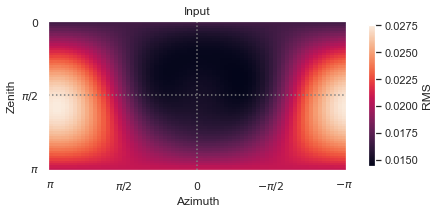

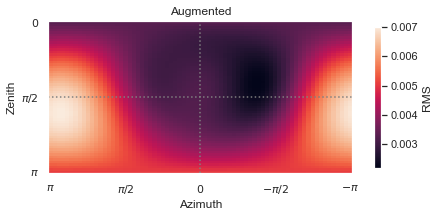

In [17]:
plots.sh_rms_map(batch[batch_id, :, 0:fs*2], INDB=False, title='Input')
plots.sh_rms_map(audio_aug_single[:, 0:fs*2], INDB=False, title='Augmented')